In [87]:
# import warnings
warnings.filterwarnings("ignore")

In [88]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
%matplotlib inline
plt.style.use('bmh')

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [91]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

#### Reading Data

In [93]:
time_series_df = pd.read_csv("../data/gun_violence_cleaned_data_2013_2018.csv")

Monthly modifications are being done to the data.

In [95]:
time_series_df['date'] = pd.to_datetime(time_series_df['date'])
time_series_df['monthyear'] = time_series_df['date'].dt.to_period('M')

monthly_incidents = time_series_df.groupby('monthyear').size()
monthly_incidents.index = monthly_incidents.index.to_timestamp()

In [96]:
indices = []
for i in range(time_series_df.shape[0]):
    if 'mass' in time_series_df['incident_characteristics'].iloc[i]:
        indices.append(i)
df_mass = time_series_df.iloc[indices]

In [97]:
sns.set_theme(style="whitegrid")

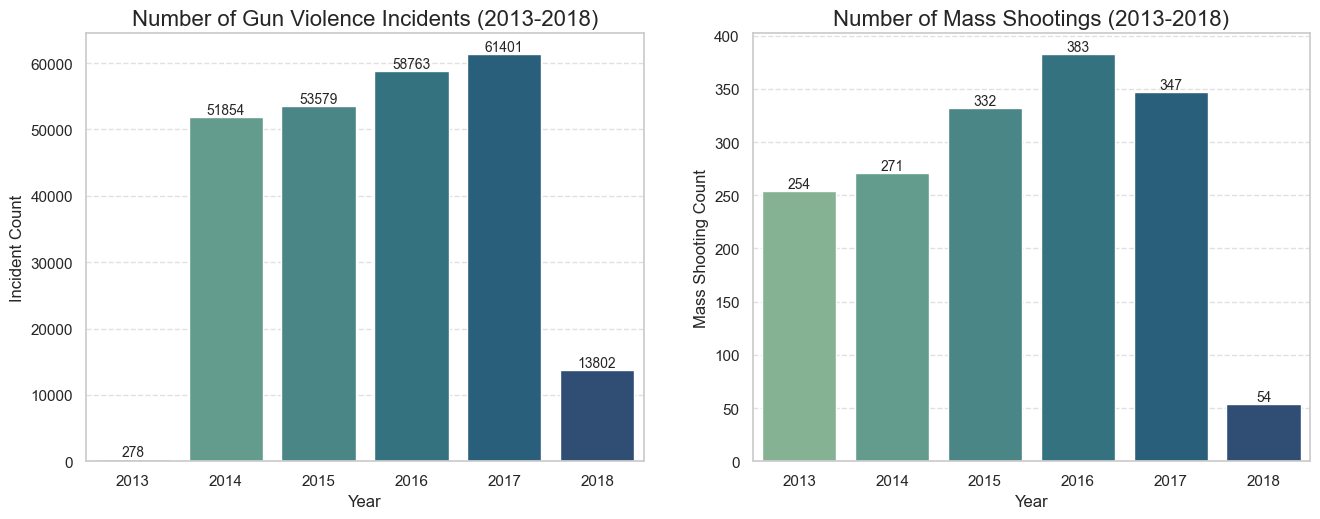

In [98]:
year_palette = sns.color_palette("crest", len(time_series_df['year'].unique()))
plt.figure(figsize=(14, 6))

plt.subplot(121)
ax1 = sns.countplot(x='year', data=time_series_df, order=sorted(time_series_df['year'].unique()), palette=year_palette)
for bar in ax1.patches:
    ax1.annotate(f"{int(bar.get_height())}", 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10)
ax1.set_title('Number of Gun Violence Incidents (2013-2018)', fontsize=16)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Incident Count', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

plt.subplot(122)
ax2 = sns.countplot(x='year', data=df_mass, order=sorted(df_mass['year'].unique()), palette=year_palette)
for bar in ax2.patches:
    ax2.annotate(f"{int(bar.get_height())}", 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10)
ax2.set_title('Number of Mass Shootings (2013-2018)', fontsize=16)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Mass Shooting Count', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(pad=3)
plt.show()

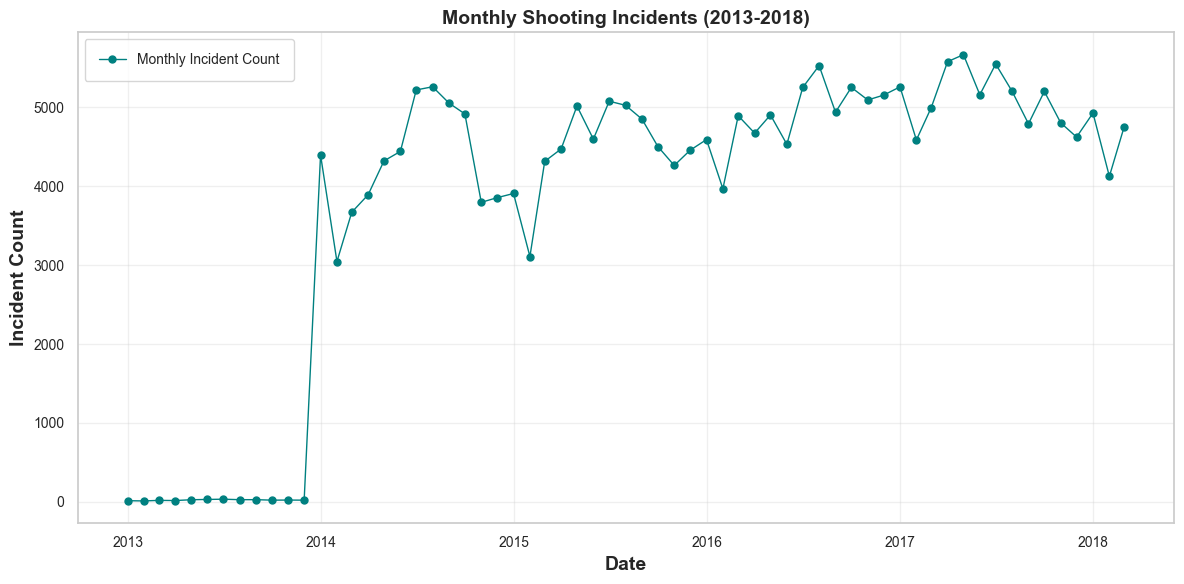

In [99]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_incidents, color='teal', linewidth=1, marker='o', markersize=5, label="Monthly Incident Count")
plt.title("Monthly Shooting Incidents (2013-2018)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=14, fontweight='bold')
plt.ylabel("Incident Count", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(alpha=0.3)
plt.legend(loc="upper left", fontsize=10, frameon=True, borderpad=1)
plt.tight_layout()
plt.show()

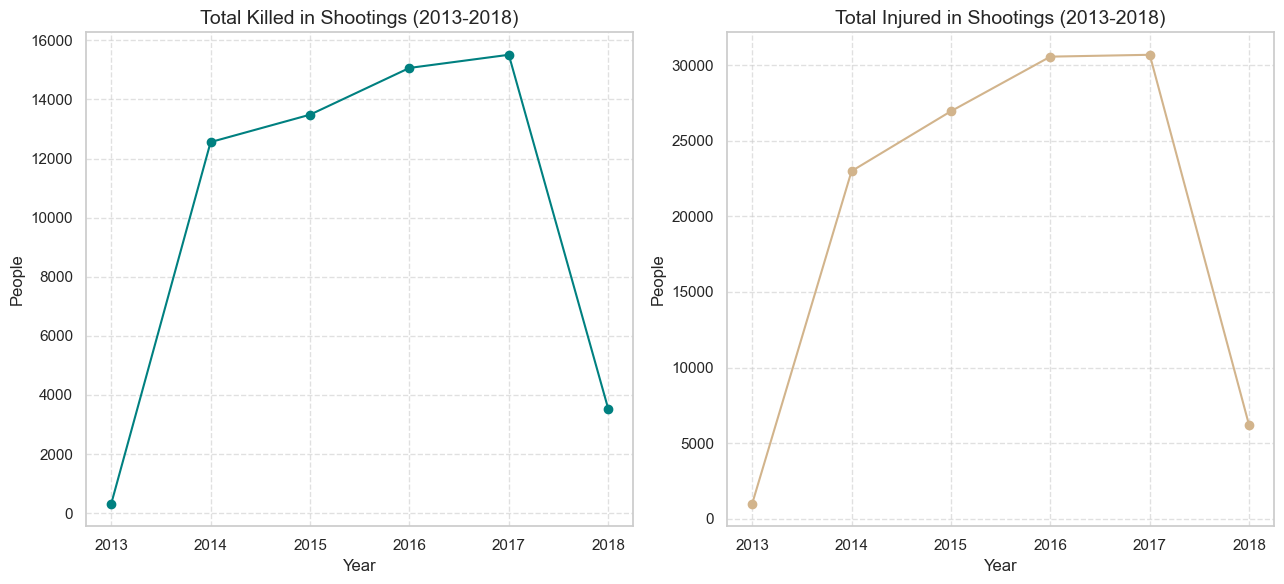

In [100]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.title("Total Killed in Shootings (2013-2018)", fontsize=14)
plt.ylabel("People")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_killed'].sum(), marker='o', color='teal', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(122)
plt.title("Total Injured in Shootings (2013-2018)", fontsize=14)
plt.ylabel("People")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_injured'].sum(), marker='o', color='tan', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

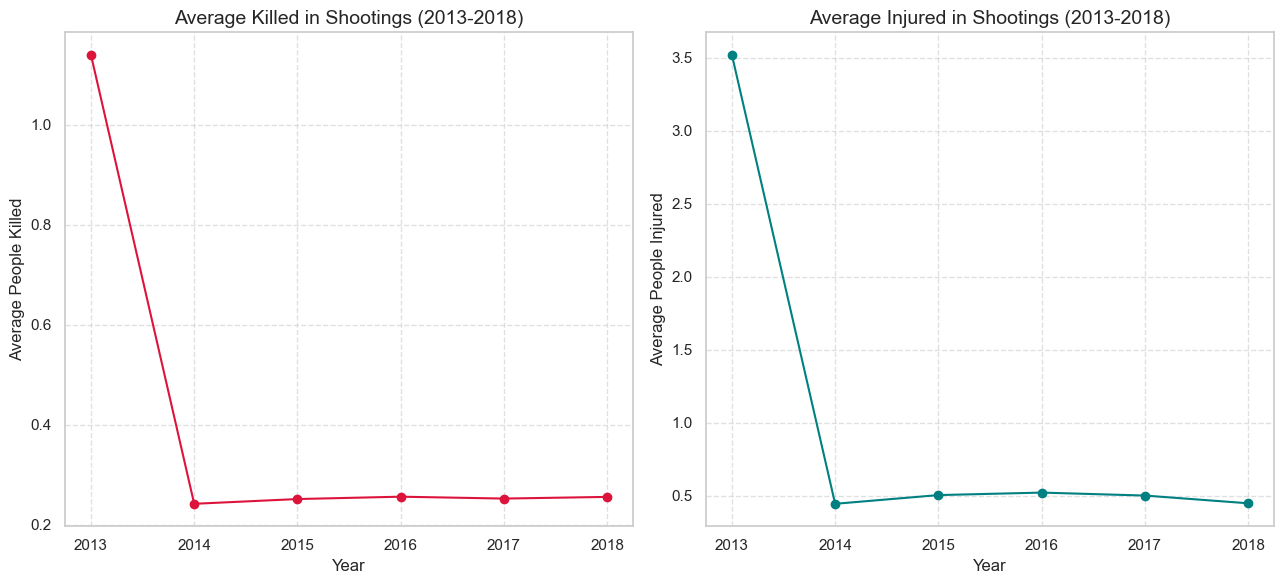

In [101]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.title("Average Killed in Shootings (2013-2018)", fontsize=14)
plt.ylabel("Average People Killed")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_killed'].mean(), marker='o', color='crimson', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(122)
plt.title("Average Injured in Shootings (2013-2018)", fontsize=14)
plt.ylabel("Average People Injured")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_injured'].mean(), marker='o', color='teal', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [102]:
time_series_df['monthyear'] = time_series_df['monthyear'].dt.to_timestamp()

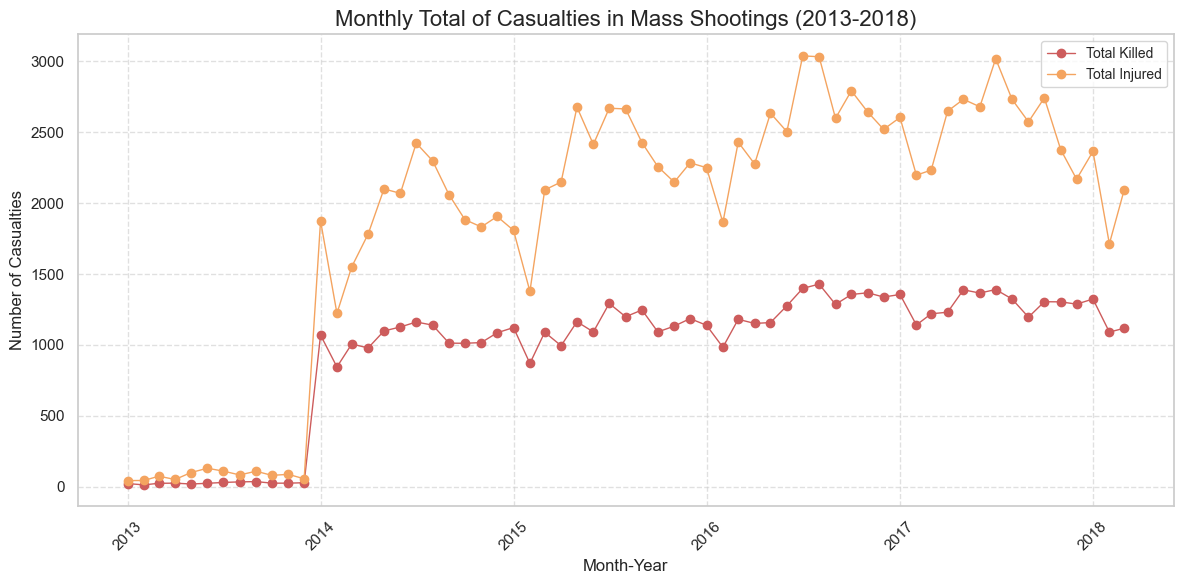

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(time_series_df.groupby('monthyear')['n_killed'].sum(), label='Total Killed', color='indianred', marker='o', linestyle='-', linewidth=1)
plt.plot(time_series_df.groupby('monthyear')['n_injured'].sum(), label='Total Injured', color='sandybrown', marker='o', linestyle='-', linewidth=1)

plt.title("Monthly Total of Casualties in Mass Shootings (2013-2018)", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Casualties", fontsize=12)

plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Time Resampling

### Augmented Dickey-Fuller (ADF) test

It helps determine if a time series is stationary or non-stationary.

Why the ADF Test is Important:
- The ADF test checks if a time series is stationary, a crucial assumption for many time series models, such as ARIMA.
- Stationary data has constant mean, variance, and autocorrelation over time, making it predictable. Non-stationary data may need transformations, like differencing, to meet model requirements.

A stationary time series has constant statistical properties, such as mean and variance, over time. This is a key assumption for many time series forecasting models.

- Trend Stationarity: The series can be made stationary by removing the trend.
- Difference Stationarity: The series becomes stationary by differencing, i.e., subtracting each data point from the previous one.

In [106]:
def perform_adf_test(time_series):
    """
    Perform the Augmented Dickey-Fuller test to assess stationarity of the time series.
    
    Parameters:
    time_series (pd.Series): The time series data to test.
    
    Returns:
    None: Prints the ADF test summary and interpretation.
    """
    result = adfuller(time_series)

    print('Augmented Dickey-Fuller Test Results:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for label, value in zip(labels, result[:4]):
        print(f"{label}: {value}")

    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")

    if result[1] <= 0.05:
        print("\nConclusion: Strong evidence against the null hypothesis (H0), suggesting the data is stationary.")
    else:
        print("\nConclusion: Weak evidence against the null hypothesis (H0), suggesting the data is non-stationary.")

In [107]:
ts = time_series_df.groupby('monthyear')['incident_id'].count().reset_index()
ts.columns = ['month','total']
ts['month'] = pd.to_datetime(ts['month'])
ts.set_index('month',inplace=True)

### Seasonal Decomposition Plots


Seasonal decomposition is the process of breaking down a time series into its components: trend, seasonality, and residuals (or noise). It helps in better understanding the underlying structure of the data, making it easier to model and forecast.

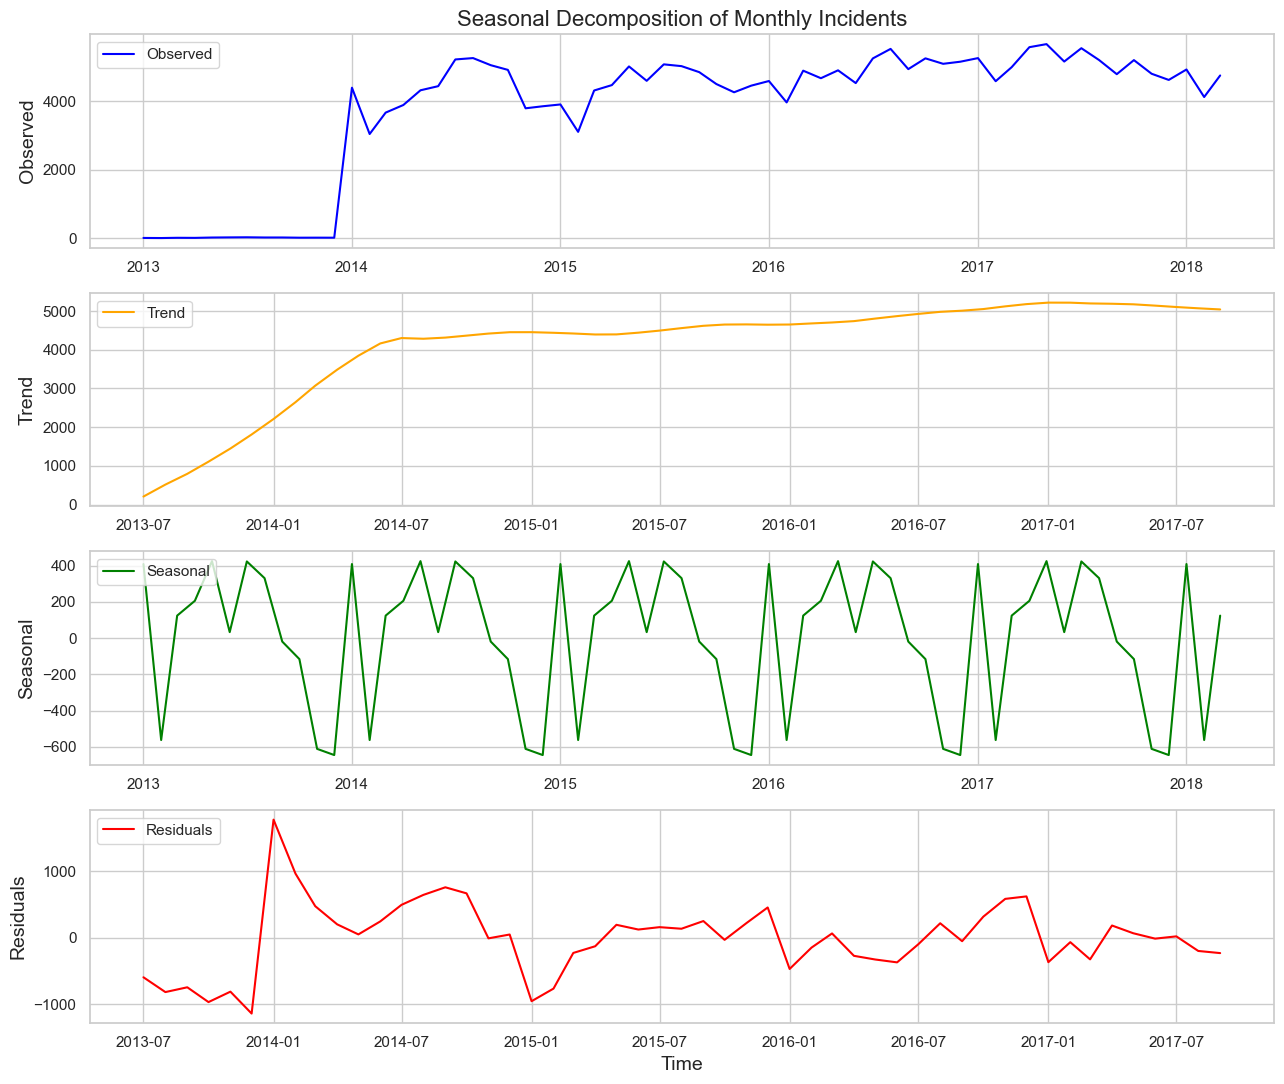

In [109]:
decomposition = seasonal_decompose(ts["total"], model='additive', period=12)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(13, 11))

axes[0].plot(decomposition.observed, color='blue', label='Observed', linewidth=1.5)
axes[0].set_title('Seasonal Decomposition of Monthly Incidents', fontsize=16)
axes[0].set_ylabel('Observed', fontsize=14)
axes[0].legend(loc='upper left')

axes[1].plot(decomposition.trend, color='orange', label='Trend', linewidth=1.5)
axes[1].set_ylabel('Trend', fontsize=14)
axes[1].legend(loc='upper left')

axes[2].plot(decomposition.seasonal, color='green', label='Seasonal', linewidth=1.5)
axes[2].set_ylabel('Seasonal', fontsize=14)
axes[2].legend(loc='upper left')

axes[3].plot(decomposition.resid, color='red', label='Residuals', linewidth=1.5)
axes[3].set_ylabel('Residuals', fontsize=14)
axes[3].set_xlabel('Time', fontsize=14)
axes[3].legend(loc='upper left')

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()

In [110]:
perform_adf_test(ts["total"])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -2.05929744286299
p-value: 0.2611929643578449
#Lags Used: 1
Number of Observations Used: 61

Critical Values:
    1%: -3.542412746661615
    5%: -2.910236235808284
    10%: -2.5927445767266866

Conclusion: Weak evidence against the null hypothesis (H0), suggesting the data is non-stationary.


The results suggest that the time series is non-stationary. This means:

- The data likely has trends, seasonality, or other patterns that prevent it from being constant over time.
- Non-stationary data can lead to inaccurate or unstable forecasts if used directly in models like ARIMA.

In [112]:
ts['first_difference'] = ts['total'] - ts['total'].shift(1)
perform_adf_test(ts['first_difference'].dropna())

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -10.757236994842238
p-value: 2.5744632543964214e-19
#Lags Used: 0
Number of Observations Used: 61

Critical Values:
    1%: -3.542412746661615
    5%: -2.910236235808284
    10%: -2.5927445767266866

Conclusion: Strong evidence against the null hypothesis (H0), suggesting the data is stationary.


### Time Series Analysis

#### **ARIMA vs. SARIMA vs. SARIMAX**
**ARIMA:**

- Stands for AutoRegressive Integrated Moving Average.
- Models only the time series data without any seasonal components.
- Best suited for non-seasonal, stationary time series.

**SARIMA:**

- Stands for Seasonal ARIMA.
- Adds a seasonal component to ARIMA to handle recurring patterns over fixed intervals (e.g., yearly seasonality for monthly data with m=12).
- Does not include exogenous variables.

**SARIMAX:**

- Stands for Seasonal ARIMA with eXogenous variables.
- Extends SARIMA by incorporating exogenous variables (independent predictors influencing the dependent time series).
- If you are not using exogenous variables, SARIMA is sufficient.

In [116]:
y_train, y_test = ts[:-12], ts[-12:]

In [117]:
model = sm.tsa.statespace.SARIMAX(y_train['total'],order=(0,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84631D+15    |proj g|=  2.24692D+20

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     46      2     0     0   2.549D+11   1.569D+09
  F =   1569333163.1652985     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                      SARIMAX Results                                       
Dep. Variable:                                total   No. Observations:                   51
Model:  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


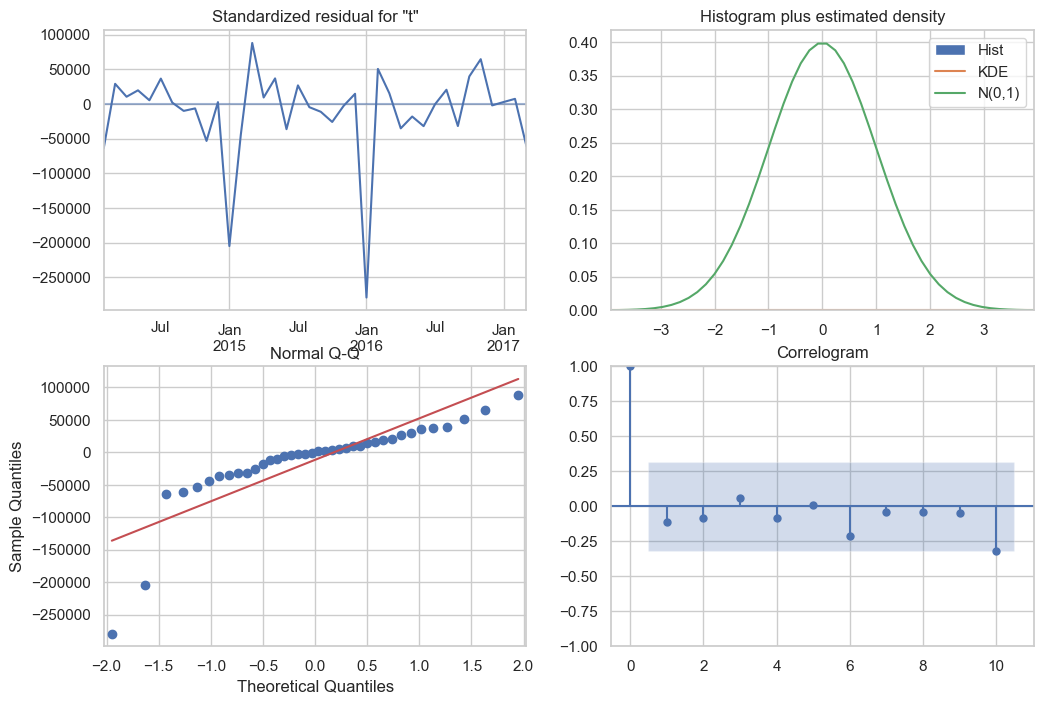

In [118]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [119]:
forecast = model_fit.forecast(steps=12)

mape = mean_absolute_percentage_error(y_test['total'], forecast)
rmse = mean_squared_error(y_test['total'], forecast, squared=False)

print(f"MAPE: {mape:.2f}, RMSE: {rmse:.2f}")

MAPE: 0.07, RMSE: 428.10


<Axes: xlabel='month'>

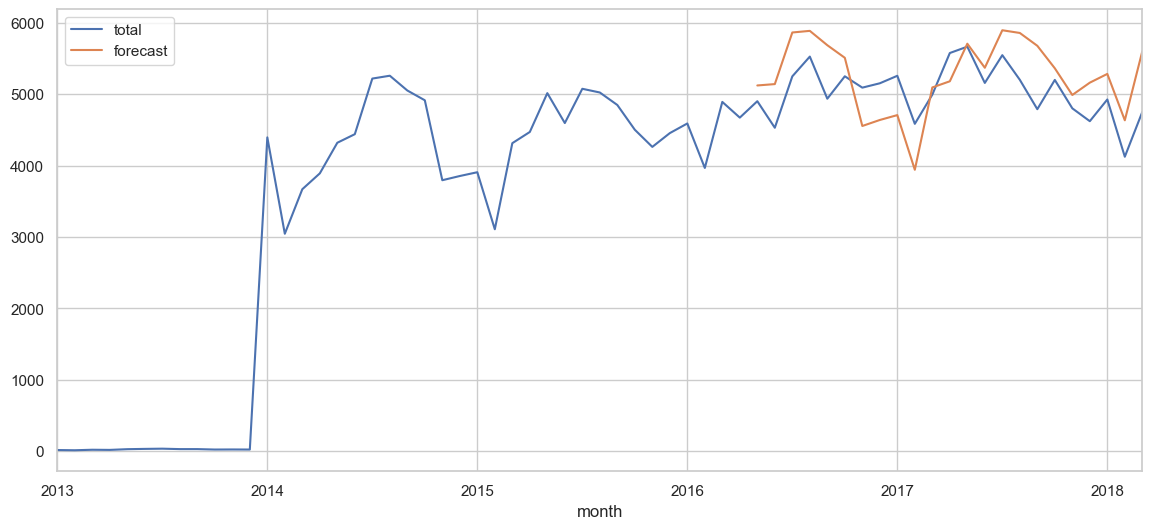

In [120]:
ts['forecast'] = model_fit.predict(start = 40, end= 62, dynamic= True)  
ts[['total','forecast']].plot(figsize=(14,6))

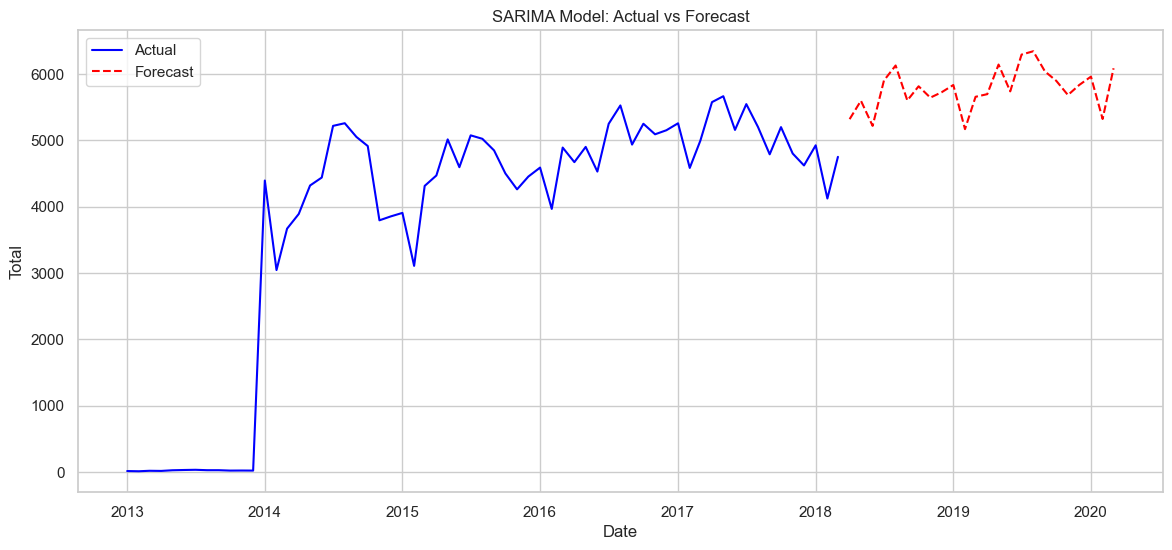

In [121]:
future_dates = [ts.index[-1] + DateOffset(months=x) for x in range(1, 25)]
future_dates_df = pd.DataFrame(index=future_dates, columns=ts.columns)
future_df = pd.concat([ts, future_dates_df])

start_idx = len(ts)
end_idx = start_idx + 23
future_df['forecast'] = model_fit.predict(start=start_idx, end=end_idx, dynamic=True)
plt.figure(figsize=(14, 6))
plt.plot(ts['total'], label="Actual", color="blue")
plt.plot(future_df['forecast'], label="Forecast", color="red", linestyle="--")
plt.legend()
plt.title("SARIMA Model: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()